# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance).

**How does it work?**
Informally, two sets are close in the Hausdorff distance if every point of either set is close to some point of the other set.  In other words, it is the greatest of all the distances from a point in one set to the closest point in the other set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from scipy.spatial.distance import directed_hausdorff
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

In [5]:
%%time
# Calculate dissimilarity using Hausdorff distance

output_list = []

for i in num_batches:
    print('Calculating hausdorff distance between 1 batch vs {} batches..'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # Calculate hausdorff distance
    dist = max(directed_hausdorff(original_data_df, batch_data_df)[0],
               directed_hausdorff(batch_data_df, original_data_df)[0])
    
    output_list.append(dist)

Calculating hausdorff distance between 1 batch vs 1 batches..
Calculating hausdorff distance between 1 batch vs 2 batches..
Calculating hausdorff distance between 1 batch vs 5 batches..
Calculating hausdorff distance between 1 batch vs 10 batches..
Calculating hausdorff distance between 1 batch vs 20 batches..
Calculating hausdorff distance between 1 batch vs 50 batches..
Calculating hausdorff distance between 1 batch vs 100 batches..
Calculating hausdorff distance between 1 batch vs 500 batches..
Calculating hausdorff distance between 1 batch vs 1000 batches..
Calculating hausdorff distance between 1 batch vs 2000 batches..
Calculating hausdorff distance between 1 batch vs 3000 batches..
Calculating hausdorff distance between 1 batch vs 6000 batches..
CPU times: user 13min 37s, sys: 9.37 s, total: 13min 46s
Wall time: 13min 46s


In [ ]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.drop(['group']).shape[0]

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.drop(['group']).columns)
shuffled_simulated_data.head()

In [ ]:
# Hausdorff distance using permuted dataset (Negative control)
permuted_dist = max(directed_hausdorff(original_data_df, shuffled_simulated_data)[0],
           directed_hausdorff(batch_data_df, shuffled_simulated_data)[0])

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_dist,
        (len(num_batches), 1)),
    index=num_batches,
    columns=['distance'])

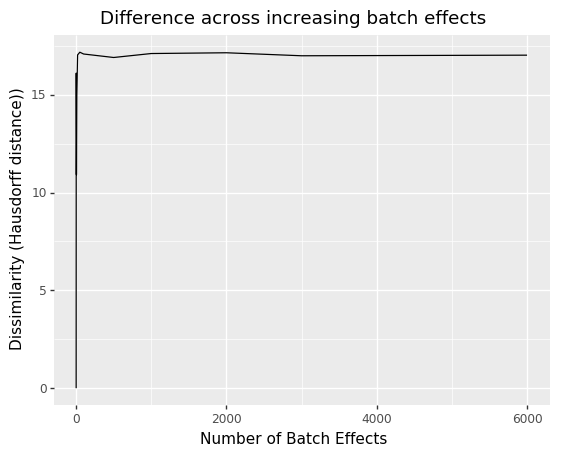

<ggplot: (8742858826486)>

In [7]:
# Plot
dist_per_batch_effect = pd.DataFrame({'num_batch_effects':num_batches, 
                                     'distance': output_list
                                    })

ggplot(dist_per_batch_effect, aes(x='num_batch_effects', y='distance')) \
    + geom_line() \
    + geom_line(aes(x=num_batches, y='distance'), threshold, linetype='dashed') \
    + xlab('Number of Batch Effects') \
    + ylab('Dissimilarity (Hausdorff distance)') \
    + ggtitle('Difference across increasing batch effects')